In [1]:
import numpy as np
import pandas

from runner import *

plotpath = parent_directory + "\\plots\\"
plotting.set_dir(plotpath)

loading complete, calculating accuracy
getting human labeled boundaries
complete


In [2]:
# pre_segmentation_image = np.array((thresholdedProcessImage > 0) + 2 * (somaImage > 0), dtype=float)
#
# plotting.colorplot(plotting.panel(pre_segmentation_image, bbox, 1), two_map, interpolation="None",
#                    name="temp")

In [2]:
"""
Here, we calculate the counts of each blank RNA, and generate the list 'usable_ids',
which is a list of all barcodes which are found at counts greater than the
95th percentile of blanks
"""

cell_rna = RNA[RNA['cell_index'] > 0].copy()

blanks = cell_rna[cell_rna['barcode_id'] < 290]
minimum = np.array(blanks['barcode_id'].value_counts().reset_index(name='counts')['counts'])[int(np.floor(290*0.05))]
print(f'minimum {minimum}')

reals = cell_rna[cell_rna['barcode_id'] > 290]

real_counts = reals['barcode_id'].value_counts().rename_axis('barcode_id').reset_index(name='counts')
usable_ids = real_counts[real_counts['counts'] > minimum]

minimum 209


In [3]:
"""
Here we produce a new rna df, with the pixel corresponding to each rna, and
track the soma and process label of each
"""
rna_p = RNA.copy()
rna_p['y'] = (np.floor(rna_p['global_y'])).astype(int)
rna_p['x'] = (np.floor(rna_p['global_x'])).astype(int)
rna_p['process'] = processImage[rna_p['y'], rna_p['x']]
rna_p['soma'] = somaImage[rna_p['y'], rna_p['x']]

In [21]:
# take only the rna which are in the usable_ids list
usable_rna = rna_p[rna_p['barcode_id'].isin(usable_ids['barcode_id'])]

# calculate frequency of each barcode by soma (start count at 1)
value_counted = usable_rna.groupby(['soma', 'barcode_id']).size().unstack(fill_value=0)
value_counted += 1.0

soma_rates = value_counted.divide(np.array(value_counted.sum(axis=1)), axis='rows')
soma_log_prob = np.log(soma_rates)

# count each barcode id by process
process_counts = usable_rna.groupby(['process', 'barcode_id']).size().unstack(fill_value=0)

barcode_id  291   292   294   296   297   298   299   301   302   303   ...  \
process                                                                 ...   
0           1560  3225  6570   908  3261   955  2073  8633  3469  1405  ...   
1              0     1     0     0     3     0     1     0     6     0  ...   
2              0     0     0     0     0     2     0     0     2     0  ...   
3              0    13     0     1     2     2     0    61     0     1  ...   
4              0     0     0     0     0     0     0     0     1     0  ...   
...          ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   
1441           0     0     0     0     0     0     0     0     0     0  ...   
1442           0     2     1     1     0     0     2     1     1     0  ...   
1444           0     0     0     0     0     0     0     0     0     0  ...   
1445           0     0     1     0     1     0     0     0     0     0  ...   
1447           0     0     0     0     0     0     0

In [5]:
from skimage.measure import regionprops
from sklearn.metrics import pairwise_distances

"""
Here, we calculate spatial information about each soma and process
"""

processprops = regionprops(processImage)
processes = pd.DataFrame({'process': [process.label for process in processprops],
                          'seed_y' : [process.coords[0, 0] for process in processprops],
                          'seed_x' : [process.coords[0, 1] for process in processprops],
                          'centroid_y' : [process.centroid[0] for process in processprops],
                          'centroid_x' : [process.centroid[1] for process in processprops]})

somaprops = regionprops(somaImage)
somas = pd.DataFrame({'soma': [soma.label for soma in somaprops],
                          'seed_y' : [soma.coords[0, 0] for soma in somaprops],
                          'seed_x' : [soma.coords[0, 1] for soma in somaprops],
                          'centroid_y' : [soma.centroid[0] for soma in somaprops],
                          'centroid_x' : [soma.centroid[1] for soma in somaprops]})

distance_mat = pairwise_distances(processes[['centroid_y', 'centroid_x']], somas[['centroid_y', 'centroid_x']])
distance_mat

array([[1177.65700862, 3414.54499201, 3244.14060443, ..., 4407.72752283,
        4405.69870469, 4346.29641815],
       [ 545.39207312, 2782.29089815, 2612.07639158, ..., 4228.00980352,
        4231.97902282, 4205.723662  ],
       [ 206.21398094, 2435.68822517, 2264.37320178, ..., 4105.95189899,
        4113.27699327, 4105.98119324],
       ...,
       [4161.26641994, 4646.20144257, 4529.23866986, ...,  250.83112848,
         208.77757232,   29.92383469],
       [4420.75904143, 5580.9379335 , 5432.61924436, ..., 1887.25091125,
        1846.40642651, 1610.40526908],
       [4349.38493233, 4255.67985523, 4174.40739308, ...,  887.97704494,
         928.11831493, 1163.64321287]])

In [23]:
from skimage.measure import label
threshold = np.array(np.array((thresholdedProcessImage > 0) + 2 * (somaImage > 0), dtype=float) > 0, dtype=float)
# plotting.colorplot(threshold, two_map)
connected = label(threshold)

In [7]:
pot_pairs = pd.DataFrame(np.argwhere(distance_mat < 300))
pot_pairs

,0,1
0,2,0
1,2,4
2,2,6
3,2,8
4,2,11
...,...,...
5283,1444,141
5284,1445,132
5285,1445,133
5286,1446,135


In [8]:
pseedy = processes['seed_y'][pot_pairs[0]]
pseedx = processes['seed_x'][pot_pairs[0]]
sseedy = somas['seed_y'][pot_pairs[1]]
sseedx = somas['seed_x'][pot_pairs[1]]

pot_pairs['connected'] = connected[pseedy,pseedx] == connected[sseedy,sseedx]

In [26]:
pot_pairs = pot_pairs[pot_pairs['connected']]
print(pot_pairs)

process_counts_np=np.zeros((processes['process'].max()+1, usable_ids['barcode_id'].max()+1))
for i, row in process_counts.iterrows():
    for key in row.keys():
        process_counts_np[row.name, key] = row[key]


log_probs_np = np.zeros((somas['soma'].max()+1, usable_ids['barcode_id'].max()+1))
for i, row in soma_log_prob.iterrows():
    for key in row.keys():
        log_probs_np[row.name, key] = row[key]

print(log_probs_np)

         0    1  connected     log_prob
0        2    0       True -1065.343079
1        2    4       True -1100.770957
2        2    6       True -1201.869775
3        2    8       True -1112.570338
4        2   11       True -1213.336159
...    ...  ...        ...          ...
5272  1440  137       True -2353.516981
5275  1441  141       True  -200.984245
5283  1444  141       True   -85.444179
5286  1446  135       True     0.000000
5287  1446  137       True     0.000000

[3735 rows x 4 columns]
[[ 0.          0.          0.         ... -5.58613309 -6.34102828
  -7.00990461]
 [ 0.          0.          0.         ... -6.78784498 -6.38237987
  -8.17413934]
 [ 0.          0.          0.         ... -5.62950782 -6.75343792
  -7.23894573]
 ...
 [ 0.          0.          0.         ... -4.45652516 -6.31282315
  -6.5359667 ]
 [ 0.          0.          0.         ... -4.63119229 -6.51826194
  -6.74140549]
 [ 0.          0.          0.         ... -5.28038977 -6.36130248
  -7.22629992]]


In [10]:
pot_pairs['log_prob'] = (log_probs_np[pot_pairs[1], :] * process_counts_np[pot_pairs[0], :]).sum(axis=1)
pot_pairs

C:\Users\Harrison\AppData\Local\Temp\ipykernel_1344\1911761049.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pot_pairs['log_prob'] = (log_probs_np[pot_pairs[1], :] * process_counts_np[pot_pairs[0], :]).sum(axis=1)


,0,1,connected,log_prob
0,2,0,True,-1065.343079
1,2,4,True,-1100.770957
2,2,6,True,-1201.869775
3,2,8,True,-1112.570338
4,2,11,True,-1213.336159
...,...,...,...,...
5272,1440,137,True,-2353.516981
5275,1441,141,True,-200.984245
5283,1444,141,True,-85.444179
5286,1446,135,True,0.000000


In [11]:
pairs = pot_pairs.loc[pot_pairs.groupby(0)['log_prob'].idxmax(), [0,1]]

assignments = {}
for i, row in pairs.iterrows():
    assignments[int(row[0])] = somas.loc[row[1], 'soma']

assigned_processes = processes[processes['process'].isin(pairs[0])]
assigned_processes['cell'] = [assignments[int(process)] for process in assigned_processes['process']]

C:\Users\Harrison\AppData\Local\Temp\ipykernel_1344\1821000760.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  assigned_processes['cell'] = [assignments[int(process)] for process in assigned_processes['process']]


In [12]:
process_cells = np.zeros(processImage.shape)
for i, row in tqdm(assigned_processes.iterrows()):
    process_cells[processImage == row['process']] = row['cell']

1287it [00:25, 50.02it/s]


In [13]:
new_cell_image = process_cells + somaImage

In [14]:
newer_rna = rna_p[['y', 'x', 'barcode_id', 'global_x', 'global_y', 'global_z']].copy()
newer_rna['cell_index'] = np.array(new_cell_image[newer_rna['y'], newer_rna['x']], dtype=int)
newer_rna['process_index'] = np.array(process_cells[newer_rna['y'], newer_rna['x']], dtype=int)

In [15]:
newer_rna

,y,x,barcode_id,global_x,global_y,global_z,cell_index,process_index
0,34,25,15,25.2720,34.3440,5.500123,0,0
1,56,12,94,12.3530,56.3429,0.197061,0,0
2,81,76,292,76.2393,81.6588,2.361537,0,0
3,114,143,301,143.1442,114.2542,4.960983,0,0
4,125,92,311,92.9736,125.2798,3.174463,0,0
...,...,...,...,...,...,...,...,...
1991679,4113,4135,1165,4135.9170,4113.4360,4.000000,0,0
1991680,4055,4169,1207,4169.1445,4055.1887,0.000000,0,0
1991681,4010,4179,1217,4179.1042,4010.9442,0.484333,0,0
1991682,4039,4160,1224,4160.4014,4039.4536,0.060109,0,0


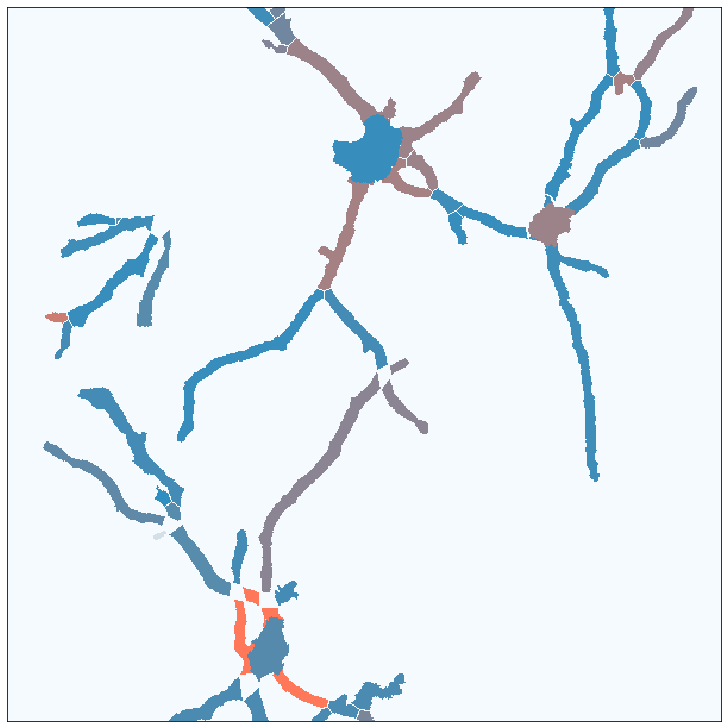

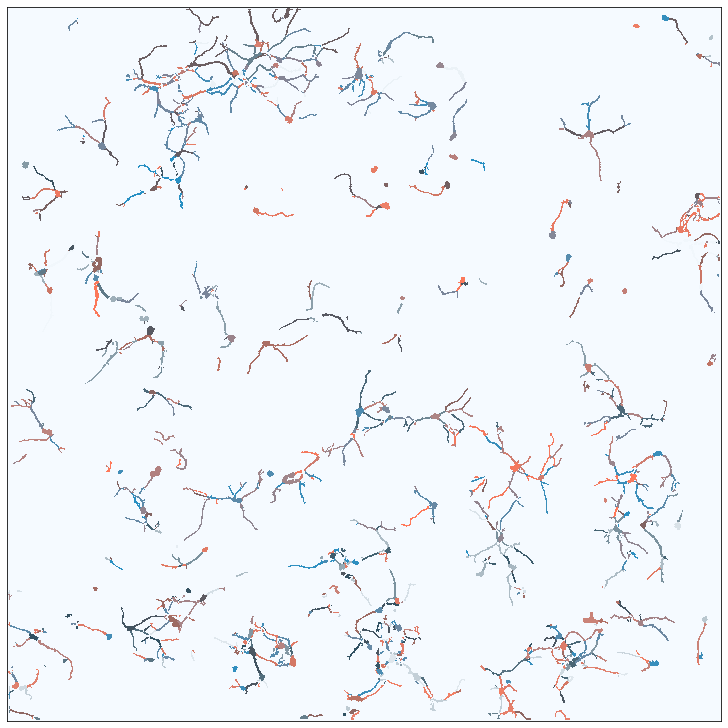

(<Figure size 720x720 with 1 Axes>, <AxesSubplot:>)

In [31]:
plotting.colorplot(plotting.permute_image(plotting.panel(new_cell_image, bbox, 1)), two_map, interpolation="None",
                   name="multinomial_assignment2")
plotting.colorplot(plotting.permute_image(new_cell_image), two_map, interpolation="None",
                   name="multinomial_full")

In [20]:
ab_a, ab_b, a_to_b, b_to_a = metrics.align_rna(RNA, newer_rna)
new_alg_master_accuracy = metrics.accuracy_set(ab_a, ab_b)

In [21]:
for test in ['process-soma', 'process-process', 'soma-soma']:
    results = new_alg_master_accuracy[test][0]
    # print([a for a in results])
    print(f'\\text{"{"}{test}{"}"} & {results["avg same cell if labeled"]:.3} & {results["avg both correclty classified and assigned if labeled"]:.3}')

for test in ['soma', 'process']:
    results = new_alg_master_accuracy[test][0]
    print([a for a in results])

\text{process-soma} & 0.224 & 0.0847
\text{process-process} & 0.473 & 0.416
\text{soma-soma} & 0.977 & 0.976
[0.9498545534710908, 0.5687316933583263, 0.8217303124987541, 0.5687316933583263]
[0.5325465027738496, 0.979535469114127, 0.7333118638736398, 0.979535469114127]
